In [1]:
import rasterio
from rasterio.plot import show
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from skimage import io
import torchvision
import torchvision.transforms as T
from torchvision import tv_tensors
from torchmetrics import F1Score
import sys
from sklearn.manifold import TSNE
from torch.utils.data import Dataset
import pandas as pd
plt.style.use('seaborn-v0_8')

sys.path.append('../Models/Networks')
from U_Net import *

In [2]:
torchvision.__version__

'0.16.0'

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [4]:
np.random.seed(8)

def brightness(i, increase = 0.5, prob = 0.5):
    if i.unique().shape[0] != 2: # Hard code
        p = np.random.random(1)
        if p < prob:
            p_inc = np.random.random(1)
            i = i*(1 + increase*p_inc)
            i[i>1] = 1.0
        else:
            p_dec = np.random.random(1)
            i = i*((1 - increase*p_dec))

    return i.float()


transform = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.5),
    # T.RandomResizedCrop((256,256), scale = (0.8,1)),
    # T.Lambda(brightness)
    ])

In [5]:
class Img_Dataset(Dataset):
    def __init__(self, img_folder, transform = None, split = 'Train'):
        self.img_folder = img_folder
        self.transform = transform
        self.split = split
        if 'IvoryCoast' in img_folder:
            self.country = 'IvoryCoast'
        elif 'Tanzania' in img_folder:
            self.country = 'Tanzania'
    
    def __len__(self):
        return sum([self.split in i for i in os.listdir(self.img_folder)])//2
    
    def plot_imgs(self, idx):
        fig, ax = plt.subplots(1,2,figsize = (12,6))
        
        im, g = self.__getitem__(idx)
        
        ax[0].imshow(im[[2,1,0],:,:].permute(1,2,0))
        ax[0].set_title('Planet image')
        ax[1].imshow(g[0,:,:], cmap = 'RdYlGn')
        ax[1].set_title('Cashew crops GT')
    
    def __getitem__(self, idx):
        #__getitem__ asks for the sample number idx.
        
        conversion = T.ToTensor()
        img = io.imread(fname = self.img_folder + '/Cropped' + self.country + self.split + 'StudyArea_{:05d}'.format(idx) + '.tif').astype(np.float32)
        
        # img = (img - img.min())/(img.max() - img.min())
        
        img = img/1500
        
        img[img > 1] = 1
        
        img = conversion(img).float()
        
        img = tv_tensors.Image(img)
        
        GT = io.imread(fname = self.img_folder + '/Cropped' + self.country + self.split + 'GT_{:05d}'.format(idx) + '.tif').astype(np.float32)
        
        GT = torch.flip(conversion(GT), dims = (1,))
        
        GT = tv_tensors.Image(GT)
    
        if self.transform != None:
            GT, img = self.transform(GT, img)
        
        return img, GT

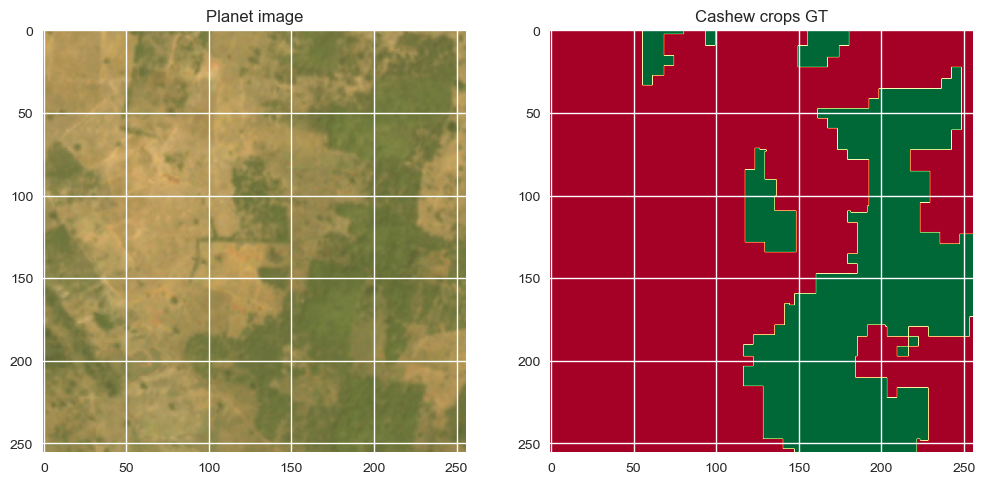

In [6]:
CIV = Img_Dataset('../Data/Planet/IvoryCoast/')
CIV.plot_imgs(1530)

## Visual assessment of distance between features extracted

In [14]:
batch_size = 4

model = torch.load('../Models/Experiments/U_Net_SourceOnlyCIV_0.1LR.pt')
model.eval()

CIV_te = Img_Dataset('../Data/Planet/IvoryCoast/', split = 'Validation')
TNZ_te = Img_Dataset('../Data/Planet/Tanzania/', split = 'Validation')

CIV_test_loader = torch.utils.data.DataLoader(dataset=CIV_te, batch_size=batch_size, shuffle=False)
TNZ_test_loader = torch.utils.data.DataLoader(dataset=TNZ_te, batch_size=batch_size, shuffle=False)

CIV_iterable_test_loader = enumerate(CIV_test_loader)
TNZ_iterable_test_loader = enumerate(TNZ_test_loader)


CIV_FE = []
TNZ_FE = []

for i, (imgs, GTs) in CIV_iterable_test_loader:
    
    features = model.FE(imgs.to(device))
    for j in range(features.shape[0]):
        CIV_FE.append(features[j].flatten().cpu().detach().numpy())

for i, (imgs, GTs) in TNZ_iterable_test_loader:
    
    features = model.FE(imgs.to(device))
    for j in range(features.shape[0]):
        TNZ_FE.append(features[j].flatten().cpu().detach().numpy())
        
CIV_te = Img_Dataset('../Data/Planet/IvoryCoast/', split = 'Test')
TNZ_te = Img_Dataset('../Data/Planet/Tanzania/', split = 'Test')

CIV_test_loader = torch.utils.data.DataLoader(dataset=CIV_te, batch_size=batch_size, shuffle=False)
TNZ_test_loader = torch.utils.data.DataLoader(dataset=TNZ_te, batch_size=batch_size, shuffle=False)

CIV_iterable_test_loader = enumerate(CIV_test_loader)
TNZ_iterable_test_loader = enumerate(TNZ_test_loader)

for i, (imgs, GTs) in CIV_iterable_test_loader:
    
    features = model.FE(imgs.to(device))
    for j in range(features.shape[0]):
        CIV_FE.append(features[j].flatten().cpu().detach().numpy())

for i, (imgs, GTs) in TNZ_iterable_test_loader:
    
    features = model.FE(imgs.to(device))
    for j in range(features.shape[0]):
        TNZ_FE.append(features[j].flatten().cpu().detach().numpy())

In [15]:
df_ = pd.DataFrame(TNZ_FE)
df_['domain'] = 'target'
df = pd.DataFrame(CIV_FE)
df['domain'] = 'source'
# df = df.sample(len(df_), random_state = 8) #  To get same amount of images per domain

In [16]:
df = pd.concat([df, df_])
X = df.iloc[:,:-1]

In [17]:
comps = 2

tsne = TSNE(comps, perplexity = 50, n_iter =  1500, random_state=8)

FE_tsne = tsne.fit_transform(X)

C:\Users\mdomi\miniconda3\envs\pytorch_eval\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mdomi\miniconda3\envs\pytorch_eval\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mdomi\miniconda3\envs\pytorch_eval\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mdomi\miniconda3\envs\pytorch_eval\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future versi

Text(0.5, 1.0, 't-SNE of features extracted for test and validation datasets\nof each domain using U-Net DANN 3 Up-Layer model')

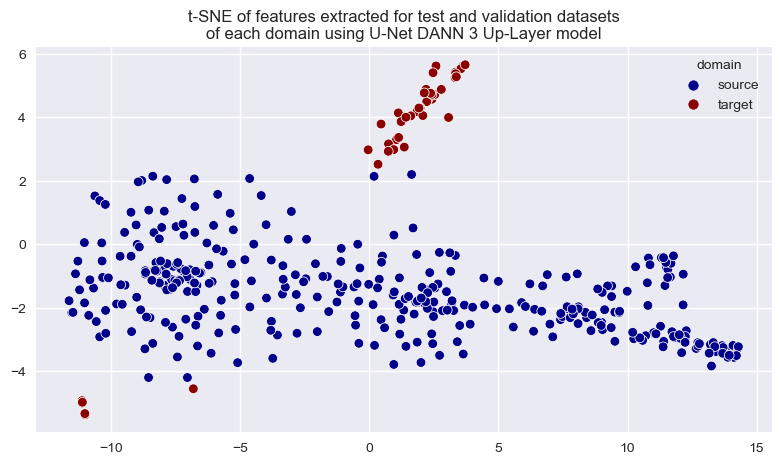

In [18]:
fig, ax = plt.subplots(1,1,figsize = (9.5,5))

sns.scatterplot(x = FE_tsne[:,0], y = FE_tsne[:,1], hue = df['domain'], ax = ax, palette = ['darkblue', 'darkred'])

ax.set_title('t-SNE of features extracted for test and validation datasets\nof each domain using U-Net DANN 3 Up-Layer model')

# fig.savefig('../imgs/t_SNE_U_NET_DANN_FeaturesExtracted_3Layer.png')

## Mean euclidean distance

In [19]:
mean_domains = df.groupby('domain').mean().T

euc_dist = np.sqrt(np.sum((mean_domains['source'] - mean_domains['target'])**2))

In [20]:
euc_dist

251.67137

In [ ]:
for i in range(len(df[df['domain'] == 'target'])):
    np.sqrt(np.sum((df[df['domain'] == 'source'] - df[df['domain'] == 'target'].iloc[0])**2, axis = 1))

In [82]:
distances = [72, 182, 118, 127]

In [13]:
model

NameError: name 'Model' is not defined